# Demonstrates how to compute Kernel Feedbacks with a couple of options for normalization

The code is minimally described at https://github.com/tyfolino/climkern (but do not clone it!) 

I've repeated the climkern instructions to make an python environment that has the climkern package. I've enhanced it to make figures, etc. here. 
You'll likely first need to module load conda as I've shown here. I ran these commands from $WORK/conda-envs but I don't think it matters. 
Be sure to do these steps one at a time, waiting between and answering "y" as needed:

    module load conda
    conda create -n ck_env python=3.10 esmpy -c conda-forge
    conda activate ck_env
    pip install ipykernel
    pip install xgcm
    pip install matplotlib
    pip install cartopy
    pip install climkern
    python -m ipykernel install --user --name=ck_env

Once installed, ClimKern requires kernels found on Zenodo. These kernels and tutorial data total >5GB so this takes about 12 min. You can do ONE of the following

    1) Make a soft link to the data in my directory

    cd $WORK/conda-envs/ck_env/lib/python3.10/site-packages/climkern
    ln -s /glade/work/bitz/conda-envs/ck_env/lib/python3.10/site-packages/climkern/data
    cd $WORK/conda-envs/

    OR 2) get the data yourself (either copy it from my directory which is a bit faster) or get it from Zenodo yourself:

    python -m climkern download

The original author offers a pytest that is optional. It takes a few minutes and then it gave me a warning "Expected 16 from C header, got 96 from PyObject". 
So far it hasn't seemed to matter, so I don't think you need to bother with it. But if you do install it, you'll need to run it using the full path. It gets installed in  $WORK/conda-envs/ck_env/bin/pytest


You'll need to select the ck_env kernel environment to run this script. I had to close and shutdown the notebook and re-open it, then change kernel to ck_env

To use the code, I found the documentation on github helpful but kind of incomplete. I found the documentation in the following code also helpful so I've repeated here:

From $WORK/conda-envs/ck_env/lib/python3.10/site-packages/climkern/frontend.py

def calc_alb_feedback(
    ctrl_rsus: DataArray,
    ctrl_rsds: DataArray,
    pert_rsus: DataArray,
    pert_rsds: DataArray,
    kern: str = "GFDL",
    sky: str = "all-sky",
) -> DataArray:

    Calculate the radiative perturbation (W/m^2) from changes in surface                                                                              
    albedo using user-specified radiative kernel. Horizontal resolution                                                                               
    is kept at input data's resolution.                                                                                                               
                                                                                                                                                      
    Parameters                                                                                                                                        
    ----------                                                                                                                                        
    ctrl_rsus : xarray DataArray                                                                                                                      
        DataArray containing the upwelling SW radiation at the surface in the                                                                         
        control simulation. Must be 3D with coordinates of time, latitude, and                                                                        
        longitude with units of W/m^2.                                                                                                                
                                                                                                                                                      
    ctrl_rsds : xarray DataArray                                                                                                                      
        DataArray containing the downwelling SW radiation at the surface in                                                                           
        the control simulation. Must be 3D with coordinates of time, latitude,                                                                        
        and longitude with units of W/m^2.                                                                                                            
                                                                                                                                                      
    pert_rsus : xarray DataArray                                                                                                                      
        DataArray containing the upwelling SW radiation at the surface in the                                                                         
        perturbed simulation. Must be 3D with coordinates of time, latitude,                                                                          
        and longitude with units of W/m^2.                                                                                                            
                                                                                                                                                      
    pert_rsds : xarray DataArray                                                                                                                      
        DataArray containing the downwelling SW radiation at the surface in                                                                           
        the perturbed simulation. Must be 3D with coordinates of time,                                                                                
        latitude, and longitude with units of W/m^2.                                                                                                  
                                                                                                                                                      
    kern : string, optional                                                                                                                           
        String specifying the name of the desired kernel. Defaults to "GFDL".                                                                         
                                                                                                                                                      
    sky : string, optional                                                                                                                            
        String, either "all-sky" or "clear-sky", specifying whether to                                                                                
        calculate the all-sky or clear-sky feedbacks. Defaults to "all-sky".                                                                          
                                                                                                                                                      
    Returns                                                                                                                                           
    -------                                                                                                                                           
    alb_feedback : xarray DataArray                                                                                                                   
        3D DataArray containing radiative perturbations at TOA caused by                                                                              
        changes in surface albedo with coordinates of time, latitude, and                                                                             
        longitude.                                                                                                                                    

Finally there are some definitions used in the climkern tutorial code that are from Smith et al (2020) https://acp.copernicus.org/articles/20/9591/2020/acp-20-9591-2020.pdf
However, I didn't wind up doing any cloud feedback calculations other than the simple Cloud Radiative Effect (CRE) that is the all sky minus clear sky TOM LW or SW flux difference

Effective radiative forcing (ERF) is the TOM flux difference between a perturbed and control FixedSST simulations $\Delta$ FLNT - $\Delta$ FSNT, with no 
correction for land surface temperature change.

Effective radiative forcing using a Gregory regression (ERF_reg). ERF_reg is calculated from the perturbed fully-coupled simulation from extrapolating the Gregory Plot back to the y-axis intercept using the first 30 years of output. The piControl fully-coupled simulation has essentially zero net flux at TOM so we don't have to remove it.

Instantaneous forcing (IRF) is calculated as the difference of the ERF and the sum of adjustments

If not provided, ClimKern will assume a tropopause height of            
        300 hPa at the equator, linearly decreasing with the cosine of                  
        latitude to 100 hPa at the poles.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors
import scipy.interpolate as interp
from xgcm import Grid
import climkern as ck
import pandas as pd
import numpy as np
import xarray as xr

In [2]:
#ctrl,pert = ck.tutorial_data('ctrl'),ck.tutorial_data('pert') # These data were provided by the author, we won't use them here, this is FYI
#ctrl['plev'].values

In [3]:
ddir ='/glade/derecho/scratch/bitz/ADF/climo/FullyCoupled/'
thevars=['Q','T','TS','FLNS','FLNT','LWCF','FSNS','FSNT','SWCF','PS','TS','FLUT', 'FLUTC', 'FSNSC', 'FLNSC','FSDS']

plev = np.array([  364.3465694 ,   759.48196463,  1435.66322513,  2461.22200042,
        3826.82997733,  5459.54797417,  7201.2450546 ,  8782.12302923,
       10331.71266317, 12154.72407639, 14299.40387607, 16822.50797749,
       19790.80867022, 23282.86189586, 27391.08167589, 32224.19023514,
       37910.09038687, 44599.25740957, 52468.71747077, 60977.86948085,
       69138.94303143, 76340.4481113 , 82085.83686501, 85953.4766525 ,
       88702.02489197, 91264.45469446, 93619.83984709, 95748.54795355,
       97632.54073914, 99255.60951233])

def CombineDSNicelyNregrid(ddir,casename,thevars):  # combine the cases for a few variables into a nice xarray DataSet
    x_all=[]
    for i,avar in enumerate(thevars):
        x = xr.open_dataset(ddir+casename+'_'+avar+'_climo.nc')
        x['time'] = np.arange(1,13) # fix some of my times
        if i==0:
            x_all = x
        else:
            x_all=xr.merge([x_all, x],compat='override')
    x_all['FLNTC']=x_all['LWCF']+x_all['FLNT']
    x_all['FSNTC']=x_all['SWCF']+x_all['FSNT'] 
    x_all['FSUS']=-x_all['FSNS']+x_all['FSDS']  
    Tplev = regrid_xgcm(x_all, x_all['PS'], plev/100., 'T')
    Tplev.name = 'T'
    Tplev['plev'] = Tplev['plev']*100.
    Qplev = regrid_xgcm(x_all, x_all['PS'], plev/100., 'Q')
    Qplev.name = 'Q'
    Qplev['plev'] = Qplev['plev']*100.
    x_all=x_all.drop_vars(('Q','T'))
    x_all=xr.merge([x_all,Tplev])
    x_all=xr.merge([x_all,Qplev])
    return x_all

def regrid_xgcm(ds, ps, p_target, var):
    """
    Regrid data from hybrid-sigma coordinates to constant pressure levels using xgcm
    Uses xgcm.Grid.transform
    
    Parameters
    ----------
    ds: xarray Dataset
        A dataset containing the variables to be regridded
    ps: xarray DataArray
        DataArray containing surface pressure data
    p_target: array-like
        Array containing pressure levels in hPa to interpolate to
    var: string, regrid this variable 
        
    Returns
    -------
    dsout: xarray Dataset
        A dataset containing the variables regridded onto pressure levels        
    
    """
    
    p = (ds['hyam']*ds['P0'] + ds['hybm']*ps)/100
    #print(p.max().values)
    #print(p_target)
    ds = ds.assign({'p': np.log(p)})
    grid = Grid(ds, coords={'Z': {'center': 'lev'}}, periodic=False)
    
    dsout = xr.Dataset(coords={"plev": ("plev", p_target),  # there is probablay a better way to do this automatically, helps if time is included
                              "lat": ("lat", ds.lat.data),
                              "lon": ("lon", ds.lon.data)})
    
    data = ds[var]
    varout = grid.transform(data,
                            'Z',
                            np.log(p_target),
                            target_data=ds.p)
    varout = varout.rename({"p": "plev"})
    varout = varout.assign_coords({'plev': p_target})
    dsout = dsout.assign({var: varout})
    dsout = dsout[var]
    return dsout

# individual plots
def plotprojection(field,title):
    # Create figure with PlateCarree projection
    projection = ccrs.Robinson(central_longitude=0)
    transform = ccrs.PlateCarree(central_longitude=0)
    fig, axs = plt.subplots(1, 1, figsize=(2.2, 1.5), 
        subplot_kw=dict(projection=projection),
        dpi=300)
    mesh = axs.pcolormesh(field.lon.data, field.lat.data, 
                             field.data, cmap='coolwarm',
                             transform=transform, vmin=-4.5, vmax=4.5)
    cbar = plt.colorbar(mesh, ax=axs, orientation='horizontal', shrink=0.95, pad=0.05)
    #cbar.set_label(f'Lapse Rate Adjustment \n in $W m^{-2}$',size=6)
    cbar.set_label(title,size=4)
    cbar.ax.tick_params(labelsize=4)
    cbar.ax.set_xscale('linear')
    axs.coastlines()
    return

def plotAllFB(ddict,fields,title):
    projection = ccrs.Robinson(central_longitude=0)
    transform = ccrs.PlateCarree(central_longitude=0)
    fig, axs = plt.subplots(3, 2, figsize=(5, 5), 
        subplot_kw=dict(projection=projection),
        dpi=300)
    axs = axs.reshape(-1)
    i=0
    for thevar in fields:
        field = ddict[thevar]
        mesh = axs[i].pcolormesh(field.lon.data, field.lat.data, 
                                 field.data, cmap='coolwarm', vmin=-4.5, vmax=4.5,
                                 transform=transform)
        axs[i].coastlines()
        axs[i].set_title(thevar,size=4)
        i=i+1
    fig.subplots_adjust(bottom=0.15)
    cbar_ax = fig.add_axes([0.23, 0.12,  0.6, 0.02])
    cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='horizontal', shrink=0.95, pad=0.05)
    cbar.set_label(title,size=5)
    cbar.ax.tick_params(labelsize=4)
    cbar.ax.set_xscale('linear')
    return

In [4]:
fields=['LR','Planck','Albedo','WV','CRE_SW','CRE_LW']

def ComputeAllSkyFBs(ctrl, pert):
    """
    This routine returns a dicitionary of all the FB and CRE together
    Ignore the warnings about units.

    I'm computing the time mean here, you can change if you wish
    """
    LR, Planck = ck.calc_T_feedbacks(ctrl.T,ctrl.TS,ctrl.PS,
                                    pert.T,pert.TS,pert.PS, #pert.TROP_P,
                                    kern="GFDL")
    Albedo = ck.calc_alb_feedback(ctrl.FSUS, ctrl.FSDS, 
                                   pert.FSUS, pert.FSDS,
                                    kern="GFDL")
    lw_q, sw_q = ck.calc_q_feedbacks(ctrl.Q,ctrl.T,ctrl.PS,
                                    pert.Q,pert.PS, #pert.TROP_P,
                                    kern="GFDL")
    dCRE_SW = ck.calc_dCRE_SW(ctrl.FSNT, pert.FSNT, ctrl.FSNTC, pert.FSNTC)
    dCRE_LW = ck.calc_dCRE_LW(ctrl.FLNT, pert.FLNT, ctrl.FLNTC, pert.FLNTC)
    
    dTS = pert.TS - ctrl.TS
    dTS_glob_avg = ck.spat_avg(dTS)
    dTS_zonal=dTS.mean(dim='lon')
    
    
    ddict = {}
    ddict['LR'] = LR.mean(dim='time')/dTS_glob_avg.mean(dim='time')
    ddict['Planck'] = Planck.mean(dim='time')/dTS_glob_avg.mean(dim='time')
    ddict['Albedo'] = Albedo.mean(dim='time')/dTS_glob_avg.mean(dim='time')
    ddict['WV'] = (sw_q+lw_q).mean(dim='time')/dTS_glob_avg.mean(dim='time')
    ddict['CRE_SW'] = dCRE_SW.mean(dim='time')/dTS_glob_avg.mean(dim='time')
    ddict['CRE_LW'] = dCRE_LW.mean(dim='time')/dTS_glob_avg.mean(dim='time')
    dictglobnorm=ddict # normalized by dTS global mean

    ddict = {}
    ddict['LR'] = LR.mean(dim='time')/dTS_zonal.mean(dim='time')
    ddict['Planck'] = Planck.mean(dim='time')/dTS_zonal.mean(dim='time')
    ddict['Albedo'] = Albedo.mean(dim='time')/dTS_zonal.mean(dim='time')
    ddict['WV'] = (sw_q+lw_q).mean(dim='time')/dTS_zonal.mean(dim='time')
    ddict['CRE_SW'] = dCRE_SW.mean(dim='time')/dTS_zonal.mean(dim='time')
    ddict['CRE_LW'] = dCRE_LW.mean(dim='time')/dTS_zonal.mean(dim='time')
    dictzonalnorm=ddict # normalized by dTS zonal mean 

    ddict = {} # this one is going to be ugly
    ddict['LR'] = (LR/dTS).mean(dim='time')
    ddict['Planck'] = (Planck/dTS).mean(dim='time')
    ddict['Albedo'] = (Albedo/dTS).mean(dim='time')
    ddict['WV'] = ((sw_q+lw_q)/dTS).mean(dim='time')
    ddict['CRE_SW'] = (dCRE_SW/dTS).mean(dim='time')
    ddict['CRE_LW'] = (dCRE_LW/dTS).mean(dim='time')
    dictcellnorm=ddict  # normalized by dTS cell by cell
    
    return dictglobnorm, dictzonalnorm, dictcellnorm

def ComputeClearSkyKernels(ctrl, pert):
    """
    This routine returns a dicitionary of all the FB and CRE together
    Ignore the warnings about units.

    I'm computing the time mean here, you can change if you wish
    """
    LR, Planck = ck.calc_T_feedbacks(ctrl.T,ctrl.TS,ctrl.PS,
                                    pert.T,pert.TS,pert.PS, sky = "clear-sky", #pert.TROP_P,
                                    kern="GFDL")
    Albedo = ck.calc_alb_feedback(ctrl.FSUS, ctrl.FSDS, 
                                   pert.FSUS, pert.FSDS, sky = "clear-sky",
                                    kern="GFDL")
    lw_q, sw_q = ck.calc_q_feedbacks(ctrl.Q,ctrl.T,ctrl.PS,
                                    pert.Q,pert.PS, sky = "clear-sky",#pert.TROP_P,
                                    kern="GFDL")
    
    dTS = pert.TS - ctrl.TS
    dTS_glob_avg = ck.spat_avg(dTS)
    dTS_zonal=dTS.mean(dim='lon')
    
    ddict = {}
    ddict['LR'] = LR.mean(dim='time')/dTS_glob_avg.mean(dim='time')
    ddict['Planck'] = Planck.mean(dim='time')/dTS_glob_avg.mean(dim='time')
    ddict['Albedo'] = Albedo.mean(dim='time')/dTS_glob_avg.mean(dim='time')
    ddict['WV'] = (sw_q+lw_q).mean(dim='time')/dTS_glob_avg.mean(dim='time')
    dictglobnorm=ddict # normalized by dTS global mean

    ddict = {}
    ddict['LR'] = LR.mean(dim='time')/dTS_zonal.mean(dim='time')
    ddict['Planck'] = Planck.mean(dim='time')/dTS_zonal.mean(dim='time')
    ddict['Albedo'] = Albedo.mean(dim='time')/dTS_zonal.mean(dim='time')
    ddict['WV'] = (sw_q+lw_q).mean(dim='time')/dTS_zonal.mean(dim='time')
    dictzonalnorm=ddict # normalized by dTS zonal mean 

    ddict = {} # this one is going to be ugly
    ddict['LR'] = (LR/dTS).mean(dim='time')
    ddict['Planck'] = (Planck/dTS).mean(dim='time')
    ddict['Albedo'] = (Albedo/dTS).mean(dim='time')
    ddict['WV'] = ((sw_q+lw_q)/dTS).mean(dim='time')
    dictcellnorm=ddict  # normalized by dTS cell by cell
    
    return dictglobnorm, dictzonalnorm, dictcellnorm

In [5]:
# I'll demonstrate the Kernel Calc with this experiment and its Control
# we read in the climatologies on sigma coordinates and regrid Q and T to pressure levels
# the warning isn't currently causing any probles
DoubleCO2=CombineDSNicelyNregrid(ddir,'DoubleCO2',thevars) 
piControl=CombineDSNicelyNregrid(ddir,'piControl',thevars)

dDoubleCO2globnorm, dDoubleCO2zonalnorm, dDoubleCO2cellnorm = ComputeAllSkyFBs(piControl, DoubleCO2)
dCSDoubleCO2globnorm, dCSDoubleCO2zonalnorm, dCSDoubleCO2cellnorm = ComputeClearSkyKernels(piControl, DoubleCO2)  


# Global Mean Normalization

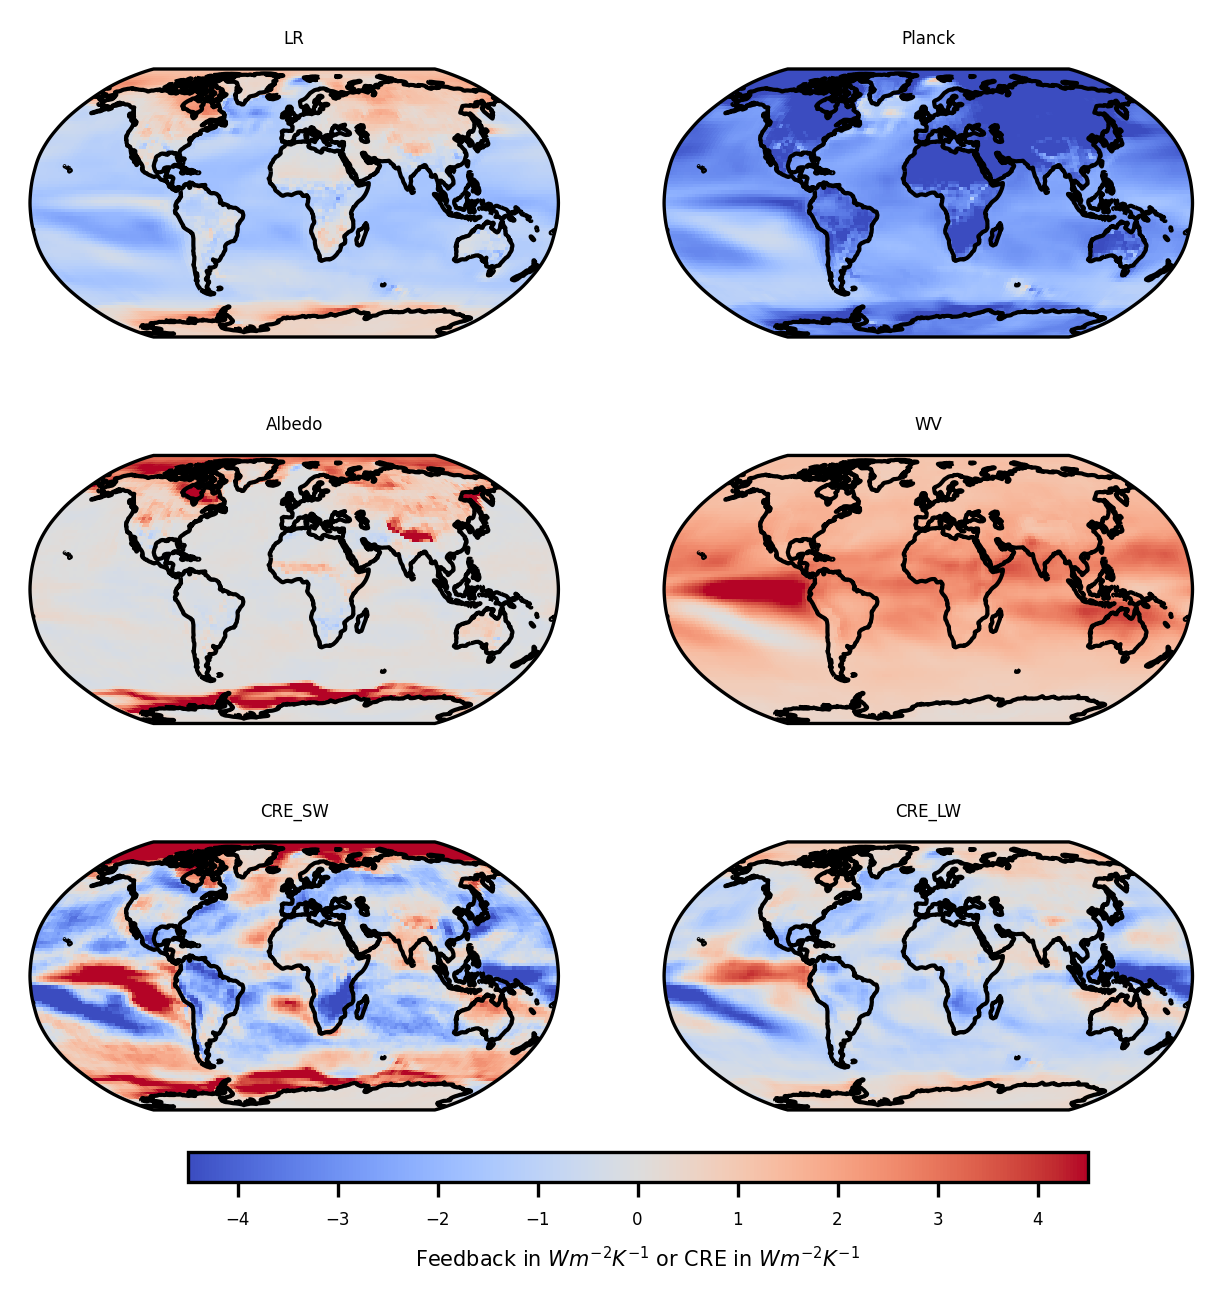

In [6]:
# takes a while since calc is done once we ask to plot the results
plotAllFB(dDoubleCO2globnorm,fields,'Feedback in $W m^{-2}K^{-1}$ or CRE in $W m^{-2}K^{-1}$')
#plt.savefig('XXXX.png') # uncomment to save a copy of this figure, etc

# Zonal Mean Normalization

In [ ]:
plotAllFB(dDoubleCO2zonalnorm,fields,'Feedback in $W m^{-2}K^{-1}$ or CRE in $W m^{-2}K^{-1}$')
# hmm this might be better done by taking the time means before normalizing so there are no divide by zeros in the Arctic during summer

# More plots of interest, etc

In [ ]:
dDoubleCO2zonalnorm['Planck'].mean(dim='lon').plot(label='All Sky')
dCSDoubleCO2zonalnorm['Planck'].mean(dim='lon').plot(label='Clear Sky')
plt.title('Planck Feedback Clear Sky vs All sky',size=24)
plt.ylabel('$W~m^{-2}~K^{-1}$',size=18)
plt.legend()

In [ ]:
dDoubleCO2zonalnorm['WV'].mean(dim='lon').plot(label='All Sky')
dCSDoubleCO2zonalnorm['WV'].mean(dim='lon').plot(label='Clear Sky')
plt.title('WV Feedback Clear Sky vs All sky',size=24)
plt.ylabel('$W~m^{-2}~K^{-1}$',size=18)
plt.legend()

In [ ]:
dDoubleCO2zonalnorm['Albedo'].mean(dim='lon').plot(label='All Sky')
dCSDoubleCO2zonalnorm['Albedo'].mean(dim='lon').plot(label='Clear Sky')
plt.title('Albedo Feedback Clear Sky vs All sky',size=24)
plt.ylabel('$W~m^{-2}~K^{-1}$',size=18)
plt.legend()

In [ ]:
dDoubleCO2zonalnorm['LR'].mean(dim='lon').plot(label='All Sky')
dCSDoubleCO2zonalnorm['LR'].mean(dim='lon').plot(label='Clear Sky')
plt.title('Lapse Rate Feedback Clear Sky vs All sky',size=24)
plt.ylabel('$W~m^{-2}~K^{-1}$',size=18)
plt.legend()

In [ ]:
# I'll demonstrate the Kernel Calc with this experiment and its Control
# we read in the climatologies on sigma coordinates and regrid Q and T to pressure levels
# the warning isn't currently causing any probles
QuadrupleCO2=CombineDSNicelyNregrid(ddir,'b.e21.BCO2x4.f19_g17.CMIP6-abrupt4xCO2-2deg.001',thevars) 
CMIP6piControl=CombineDSNicelyNregrid(ddir,'b.e21.B1850.f19_g17.CMIP6-piControl-2deg.001',thevars)

dQuadrupleCO2globnorm, dQuadrupleCO2zonalnorm, dQuadrupleCO2cellnorm = ComputeAllSkyFBs(CMIP6piControl, QuadrupleCO2)
dCSQuadrupleCO2globnorm, dCSQuadrupleCO2zonalnorm, dCSQuadrupleCO2cellnorm = ComputeClearSkyKernels(CMIP6piControl, QuadrupleCO2)  


In [ ]:
dDoubleCO2zonalnorm['WV'].mean(dim='lon').plot(label='2XCO2')
dQuadrupleCO2zonalnorm['WV'].mean(dim='lon').plot(label='4XCO2')
plt.title('WV Feedback Delendency on Forcing?',size=24)
plt.ylabel('$W~m^{-2}~K^{-1}$',size=18)
plt.legend()